In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import cv2
import time

from PIL import Image
from scipy.ndimage import rotate

import pytesseract
import easyocr

In [2]:
# Ignore notebook warings
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Path to pytesseract-ocr executable. See readme for installation.
pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'
custom_config='--psm 6 --oem 3 -c tessedit_char_whitelist=W0123456789'

# Create an easyocr reader object
reader = easyocr.Reader(['en'])
allow_list='w0123456789'

In [4]:
# generate_label_mask
def generate_label_mask(scan):
    """
    Finds the labels on the sheet and returns a mask for the image.
    """
    # Grayscale image
    gray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold
    _, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    
    # Create a new image to show the contours
    contour_img = scan.copy()
    
    # Find contours
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000000]
    
    # Create an empty mask
    mask = np.zeros(contour_img.shape[:2], dtype=np.int32)  
    
    # Filter the contours and label them in the mask
    label = 1 
    for contour in large_contours:
        # Get the bounding rectangle around the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Filter based on height and length
        if w > 1000 and h > 1000: 
            label += 1
            # Draw a rectangle around the large contour
            cv2.rectangle(contour_img, (x, y), (x + w, y + h), (0, 255, 0), 30)
    
            # Fill the mask with a unique label for each contour
            cv2.rectangle(mask, (x, y), (x + w, y + h), (label), thickness=cv2.FILLED)
        
    return mask

In [5]:
# pytesseract_read_labels_read_labels
def pytesseract_read_labels(scan, mask, file_base_name, save_ocr_results=False):
    """
    Uses an OCR to read labels. The Identified text is returned in a dictionary.
    """
    # Find unique labels
    unique_labels = np.unique(mask)
    unique_labels = unique_labels[unique_labels != 0]
    
    # Create a dictionary with keys from unique_labels
    label_dict = {int(label): None for label in unique_labels}
    
    # Loop through each label and extract the corresponding region
    for label in unique_labels:
        # Create a binary mask for the current label
        label_mask = np.zeros_like(mask, dtype=np.uint8)
        label_mask[mask == label] = 1
        
        # Crop the label from the scan
        crop_label = scan[np.ix_(label_mask.any(1), label_mask.any(0))]
        # Crop a small border in case of tilted images
        crop_label = crop_label[40:crop_label.shape[0]-40, 40:crop_label.shape[1]-40]
        # Rotate label to be readable
        # crop_label = rotate(crop_label, 90)
    
        # Crop the number from the label
        crop_num = crop_label[200:1000, 0:1200] # Format: [y1:y2, x1:x2]
    
        # _, crop_num = cv2.threshold(crop_num, 200, 255, cv2.THRESH_BINARY)
            
        # Reduce crop resolution for better ocr performence
        scale_percent = 0.50 
        new_width = int(crop_num.shape[1] * scale_percent)
        new_height = int(crop_num.shape[0] * scale_percent)
        crop_num = cv2.resize(crop_num, (new_width, new_height))
        
        # Identify the text
        ocr_result = pytesseract.image_to_string(crop_num, config=custom_config)
        ocr_result = pytesseract.image_to_string(crop_num)
        ocr_result = ocr_result.replace(" ", "")
            
        # Add a "W" if only one was identified
        if ocr_result.startswith('W') and not ocr_result.startswith('WW'):
            ocr_result = 'W' + ocr_result
        
        label_dict[int(label)] = ocr_result.strip()

        if save_ocr_results:
            label_name = f"{file_base_name}_Label_{label}"
            
            # Show the region corresponding to the current label
            fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
            ax0.imshow(cv2.cvtColor(crop_label, cv2.COLOR_BGR2RGB))
            ax0.axis('off')
            ax1.imshow(cv2.cvtColor(crop_num, cv2.COLOR_BGR2RGB))
            ax1.axis('off')
            plt.suptitle(f'{label_name}: "{label_dict[int(label)]}"', fontsize=16)
            plt.savefig(f"{save_ocr_results}{label_name}.jpg")
            # plt.show()
            plt.close()
        
    return label_dict

In [6]:
# easyocr_read_labels
def easyocr_read_labels(scan, mask, file_base_name, save_ocr_results=False):
    """
    Uses an OCR to read labels. The Identified text is returned in a dictionary.
    """
    # Find unique labels
    unique_labels = np.unique(mask)
    unique_labels = unique_labels[unique_labels != 0]
    
    # Create a dictionary with keys from unique_labels
    label_dict = {int(label): None for label in unique_labels}
    
    # Loop through each label and extract the corresponding region
    for label in unique_labels:
        # Create a binary mask for the current label
        label_mask = np.zeros_like(mask, dtype=np.uint8)
        label_mask[mask == label] = 1
        
        # Crop the label from the scan
        crop_label = scan[np.ix_(label_mask.any(1), label_mask.any(0))]
        # Crop a small border in case of tilted images
        crop_label = crop_label[40:crop_label.shape[0]-40, 40:crop_label.shape[1]-40]
    
        # Crop the number from the label
        # Format: [y1:y2, x1:x2]
        # crop_num = crop_label[200:1000, 0:1200]
        crop_num = crop_label[:, 0:1500] 
            
        # Reduce crop resolution for better ocr performence
        scale_percent = 0.50 
        new_width = int(crop_num.shape[1] * scale_percent)
        new_height = int(crop_num.shape[0] * scale_percent)
        crop_num = cv2.resize(crop_num, (new_width, new_height))

        # Perform OCR on the croped number
        results = reader.readtext(crop_num, allowlist=allow_list)
        
        # Find the result with the highest confidence
        best_result = max(results, key=lambda x: x[2])
        ocr_result = best_result[1]

        # The W is translated to lower case 
        # ocr_result = ocr_result.replace("W", "w")
        
        # Add the result to the label dictionary
        label_dict[int(label)] = ocr_result.strip()
        
        # Save the image and OCR result for easy performance validation
        if save_ocr_results:
            label_name = f"{file_base_name}_Label_{label}"
            
            # Show the region corresponding to the current label
            fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7, 2))
            ax0.imshow(cv2.cvtColor(crop_label, cv2.COLOR_BGR2RGB))
            ax0.axis('off')
            ax1.imshow(cv2.cvtColor(crop_num, cv2.COLOR_BGR2RGB))
            ax1.axis('off')
            plt.suptitle(f'{label_name}: "{label_dict[int(label)]}"', fontsize=16)
            plt.savefig(f"{save_ocr_results}{label_name}.jpg")
            # plt.show()
            plt.close()
        
    return label_dict

In [7]:
# identify_wings
def filter_text_contours(image, contours, threshold=0.2):
    """
    Filters out contours with a high concentration of black pixels. 
    This is done to remove black text that might be wrongfully identified as a wing.
    """
    wing_contours = []

    for contour in contours:
        # Create a mask for the current contour
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

        # Extract the region  from the image 
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        
        total_pixels = cv2.countNonZero(mask)
        black_pixels = total_pixels - cv2.countNonZero(masked_image)

        # Show percentage
        # plt.figure(figsize=(10, 10))
        # plt.imshow(masked_image, cmap="gray")
        # plt.axis('off')
        # plt.show()
        # print(f"Percentage of black pixels: {black_pixels / total_pixels} %")
        
        # If the percentage of black pixels is below the threshold, keep the contour
        if black_pixels / total_pixels < threshold:
            wing_contours.append(contour)

    return wing_contours


def process_and_save_wing(crop, contour, out_file, m=20):
    """
    Crops the wing from the label and saves the image.
    """
    # The boundaries of the wing with a margin (m) are calculated
    x, y, w, h = cv2.boundingRect(contour)
    wing = crop[y-m:y+h+m, x-m:x+w+m]

    # The set margin (m) can result in an attempt to crop outside of the image. 
    # In this case the margin is reduced by one until this is no longer the case. 
    if not wing.any():
        while m >= 0:
            m -= 1
            wing = crop[y-m:y+h+m, x-m:x+w+m]
            if wing.any():
                break

    # The croped Wing is saved
    wing = cv2.cvtColor(wing, cv2.COLOR_BGR2RGB)
    wing = Image.fromarray(wing)
    wing.save(out_file)


def identify_wings(mask, scan, out_files_dir, file_base_name, label_dict):
    """
    Loops through the labels and identifies the wings.
    """
    # Find unique labels except for the background
    unique_labels = np.unique(mask)
    unique_labels = unique_labels[unique_labels != 0]

    # Report number of identified wings for easy validation
    num_0_wings = 0
    num_1_wings = 0
    num_2_wings = 0
    num_3_wings = 0
    
    # Loop through each label and extract the corresponding region
    for label in unique_labels:
        # Create a binary mask for the current label
        label_mask = np.zeros_like(mask, dtype=np.uint8)
        label_mask[mask == label] = 1

        # Extract the label from the scan
        crop = scan[np.ix_(label_mask.any(1), label_mask.any(0))]
        # Crop a small border in case of tilted images
        crop = crop[40:crop.shape[0]-40, 40:crop.shape[1]-40]
    
        gray_crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        # blurred_crop = cv2.medianBlur(gray_crop, 5)
        _, thresh = cv2.threshold(gray_crop, 200, 255, cv2.THRESH_BINARY_INV)
        
        # Find contours
        contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50000]
        
        # Filter out contours with a high percentage of black pixels
        filtered_contours = filter_text_contours(gray_crop, large_contours, threshold=0.2)
            
        # Sort the contours from left to right (by the x-coordinate of their bounding box)
        sorted_contours = sorted(filtered_contours, key=lambda cnt: cv2.boundingRect(cnt)[0])
    
        # Draw contours on the image for visualization
        contour_image = crop.copy()
        cv2.drawContours(contour_image, large_contours, -1, (0, 0, 0), thickness=cv2.FILLED)
    
        # Fill the contour area on the mask
        wing_mask = np.zeros_like(contour_image[:, :, 0]) 
        wing_mask = cv2.drawContours(wing_mask, large_contours, -1, 255, thickness=cv2.FILLED)
        mask_inv = cv2.bitwise_not(wing_mask)

        # Convert the color to an array with the same shape as the image
        color_layer = np.full_like(contour_image, (255, 255, 255))
        
        image_outside_colored = np.where(mask_inv[:, :, None] == 255, color_layer, crop)
        # image_outside_colored = np.where(mask_inv, gray_crop)
            
        # Crop and save identified wings 
        if len(sorted_contours) == 0:
            num_0_wings += 1
        
        elif len(sorted_contours) == 2:
            num_2_wings += 1
        
            out_file = f"{out_files_dir}{file_base_name}_Label_{label_dict[label]}_Left.jpg"
            process_and_save_wing(crop, sorted_contours[0], out_file)
            out_file = f"{out_files_dir}{file_base_name}_Label_{label_dict[label]}_Right.jpg"
            process_and_save_wing(crop, sorted_contours[1], out_file)
        
        elif len(sorted_contours) == 1:
            num_1_wings += 1
            
            out_file = f"{out_files_dir}{file_base_name}_Label_{label_dict[label]}_Only.jpg"
            process_and_save_wing(crop, sorted_contours[0], out_file)
        
        else:
            num_3_wings += 1
            
            # Draw contours on the image for visualization
            wing_contour_image = crop.copy()
            cv2.drawContours(wing_contour_image, sorted_contours, -1, (0, 0, 255), 5)
        
            # Show contours
            plt.figure(figsize=(10, 10))
            # plt.imshow(cv2.cvtColor(wing_contour_image, cv2.COLOR_BGR2RGB))
            plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            # plt.show()
            plt.savefig(f"{out_files_dir}{file_base_name}_Label_{label_dict[label]}.jpg")
            plt.close()
            
            # print(f"\tWarning: {len(large_contours)} wings were identified on label {label_dict[label]}!")


    print(f"Sheet summary:")
    print(f"\t{num_0_wings} labels with no wings")
    print(f"\t{num_1_wings} labels with one wing")
    print(f"\t{num_2_wings} labels with two wings")
    print(f"\t{num_3_wings} labels with more than two wings")

In [9]:
# Define directories
input_dir = "/mnt/c/Projects/Master/Data/WingImages/WingScans/"
output_dir = "/mnt/c/Projects/Master/Data/WingScanCrops2/"
ocr_dir = output_dir + "OCR/"

input_dir = "/mnt/c/Projects/Master/Testdata/Scans/"
output_dir = "/mnt/c/Projects/Master/Testdata/Temp/"
ocr_dir = output_dir + "OCR/"

# Start a timer 
start = time.time()

# Ensure the input directory exists
if not os.path.exists(input_dir):
    raise FileNotFoundError(f"Input directory '{input_dir}' was not found.")

# Create the output directories
os.makedirs(output_dir)
os.makedirs(ocr_dir)

# Find tif files
tif_files = [file for file in os.listdir(input_dir) if file.endswith('.tif')]

# Loop through all scans
for i, filename in enumerate(tif_files):
    # Identify file/path components
    input_file = os.path.join(input_dir, filename)
    file_base_name = filename.split(".")[0]
    
    # Check if it is a tif file
    if os.path.isfile(input_file) and filename.endswith('.tif'):
        print(f"Processing file {i+1}/{len(tif_files)}: {filename}")

        # Open and rotate the tif file
        scan = cv2.imread(input_file)
        scan = rotate(scan, 90)

        # Identify the labels
        mask = generate_label_mask(scan)

        # Identify the text on the label
        label_dict = easyocr_read_labels(scan, mask, file_base_name, save_ocr_results=ocr_dir)

        # Create a directory for every input file
        out_files_dir = output_dir + file_base_name + "/"
        os.makedirs(out_files_dir)

        # Crop the wings and save them in the directory
        identify_wings(mask, scan, out_files_dir, file_base_name, label_dict)

# Print script runtime 
end = time.time()
print(f"Runtime: {round(end - start, 2)} seconds")

Processing file 1/3: Hive01_Sheet_01.tif
Sheet summary:
	0 labels with no wings
	0 labels with one wing
	24 labels with two wings
	0 labels with more than two wings
Processing file 2/3: Hive02_Sheet_01.tif
Sheet summary:
	1 labels with no wings
	1 labels with one wing
	22 labels with two wings
	0 labels with more than two wings
Processing file 3/3: Hive04_Sheet_01.tif
Sheet summary:
	6 labels with no wings
	0 labels with one wing
	18 labels with two wings
	0 labels with more than two wings
Runtime: 388.49 seconds


In [8]:
# Testrun
scan = cv2.imread("/mnt/c/Projects/Master/Testdata/Scans/Hive01_Sheet_03.tif")
scan = rotate(scan, 90)

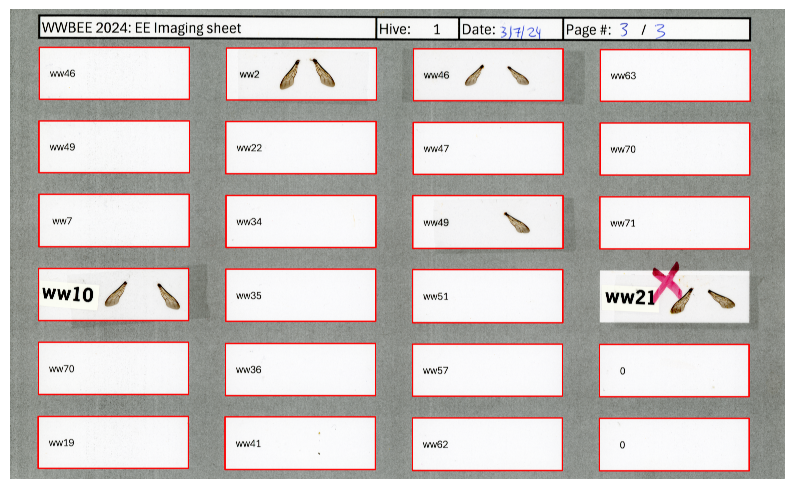

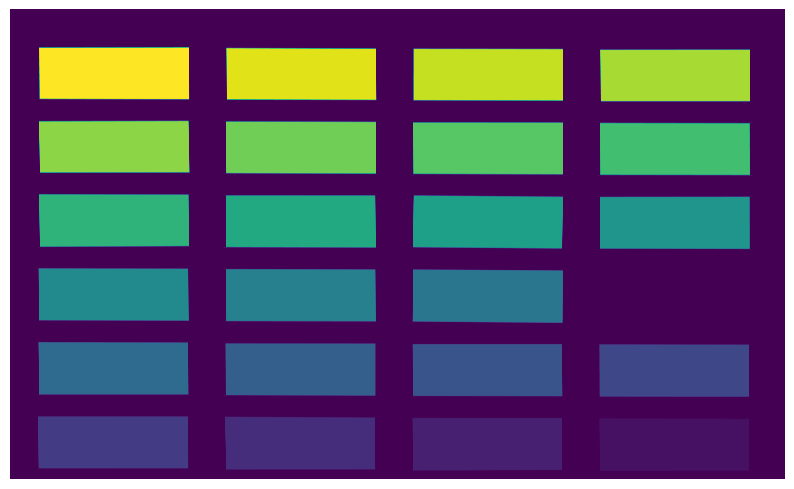

In [10]:
# generate_label_mask

# Set red and green channels to zero to ignore red marker
# scan_b = scan.copy()
# scan_b[:, :, 0] = 0
# scan_b[:, :, 1] = 0

# Grayscale image
gray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold
_, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Create a new image to show the contours
contour_img = scan.copy()

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create an empty mask
mask = np.zeros(contour_img.shape[:2], dtype=np.int32)  

# Filter the contours and label them in the mask
label = 1 
for contour in contours:
    # Approximate the contour to a polygon
    epsilon = 0.05 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    
    # Check if the contour has four corners
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        # Filter out small regions
        if w > 1000 and h > 1000:  # Might need to adjust size threshold
            # Draw a rectangle around the detected boxes
            cv2.rectangle(contour_img, (x, y), (x + w, y + h), (0, 0, 255), 30)
            # Fill the mask with a unique label for each contour
            cv2.drawContours(mask, [approx], -1, (label), thickness=cv2.FILLED)
            label += 1
            
# Send a warning if an unexpected number of labels were identified
total_labels = label-1
if total_labels != 24:
    print(f"\tWarning: {total_labels} labels were identified when 24 labels were expected!")

# Show contours
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.close()

# Show mask
plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(wing_contour_image, cv2.COLOR_BGR2RGB))
plt.imshow(mask)
plt.axis('off')
plt.show()
plt.close()

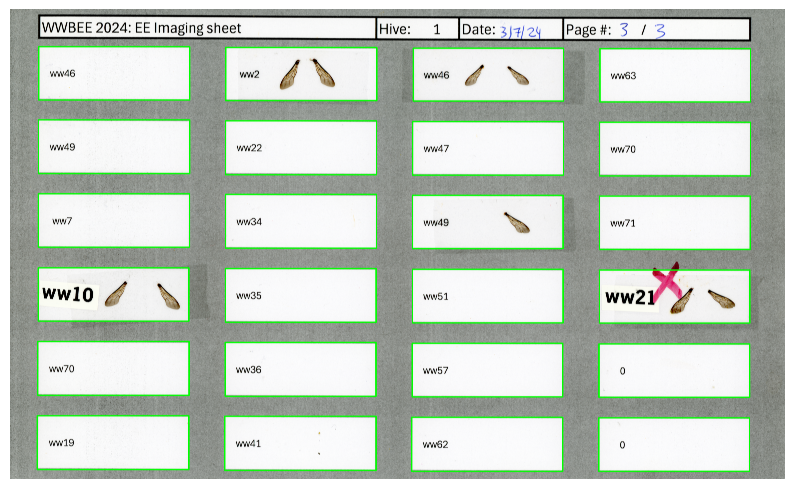

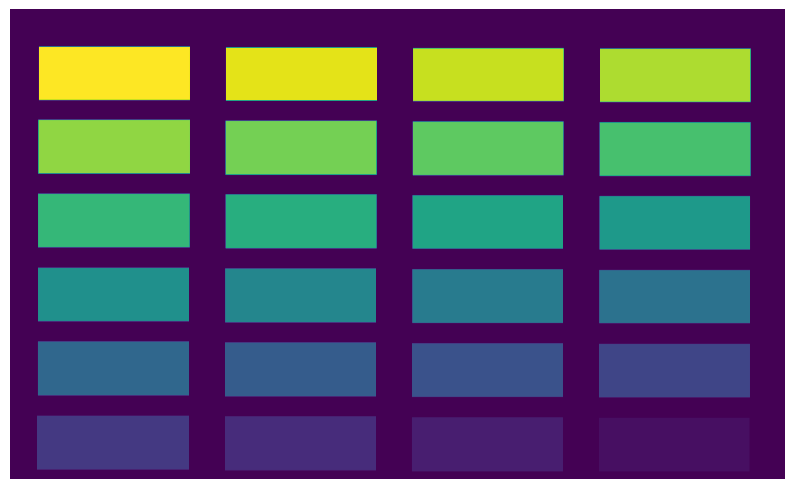

In [11]:
# generate_label_mask

# Set red and green channels to zero to ignore red marker
# scan_b = scan.copy()
# scan_b[:, :, 0] = 0
# scan_b[:, :, 1] = 0

# Grayscale image
gray = cv2.cvtColor(scan, cv2.COLOR_BGR2GRAY)

# Apply a binary threshold
_, thresholded = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Create a new image to show the contours
contour_img = scan.copy()

# Find contours
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

large_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000000]

# Create an empty mask
mask = np.zeros(contour_img.shape[:2], dtype=np.int32)  

# Filter the contours and label them in the mask
label = 1 
for contour in large_contours:
    # Get the bounding rectangle around the contour
    x, y, w, h = cv2.boundingRect(contour)
    
    # Filter based on height and length
    if w > 1000 and h > 1000: 
        label += 1
        # Draw a rectangle around the large contour
        cv2.rectangle(contour_img, (x, y), (x + w, y + h), (0, 255, 0), 30)

        # Fill the mask with a unique label for each contour
        cv2.rectangle(mask, (x, y), (x + w, y + h), (label), thickness=cv2.FILLED)
        

# Send a warning if an unexpected number of labels were identified
total_labels = label-1
if total_labels != 24:
    print(f"\tWarning: {total_labels} labels were identified when 24 labels were expected!")

# Show contours
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
plt.close()

# Show mask
plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(wing_contour_image, cv2.COLOR_BGR2RGB))
plt.imshow(mask)
plt.axis('off')
plt.show()
plt.close()


In [24]:
file_base_name = 'Hive01_Sheet_03'
label_dict = easyocr_read_labels(scan, mask, file_base_name, save_ocr_results=False)

In [25]:
identify_wings(mask, scan, out_files_dir, file_base_name, label_dict)

Sheet summary:
	19 labels with no wings
	1 labels with one wing
	3 labels with two wings
	0 labels with more than two wings


In [11]:
[file for file in os.listdir(input_dir) if file.endswith('.tif')]

['Hive01_Sheet_01.tif', 'Hive02_Sheet_01.tif', 'Hive04_Sheet_01.tif']